In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import torch
from torchvision import transforms
import numpy as np

# Code to extract zip file

In [ ]:
import os
import zipfile
import shutil

# Define the path to the zip file and the new root directory
zip_file_path = '/content/drive/MyDrive/CVProject/RICE_DATASET.zip'
new_root_directory = '/content/drive/MyDrive/CVProject'  # extract here

# Remove the "RICE_DATASET" folder if it exists
rice_dataset_path = os.path.join(new_root_directory, 'RICE_DATASET')
if os.path.exists(rice_dataset_path):
    shutil.rmtree(rice_dataset_path)

# Create the new root directory if it doesn't exist
os.makedirs(new_root_directory, exist_ok=True)

# Extract the zip file to the new root directory
folder_names = []
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in zip_ref.infolist():
        # Extract only if it's a directory
        if member.is_dir():
            folder_names.append(member.filename)

        zip_ref.extract(member, new_root_directory)

# Print all the folder names in the zip file
print("Folders in the ZIP file:")
for folder in folder_names:
    print(folder)

Folders in the ZIP file:
RICE_DATASET/
RICE_DATASET/RICE1/
RICE_DATASET/RICE1/cloudy_image/
RICE_DATASET/RICE1/ground_truth/
RICE_DATASET/RICE2/
RICE_DATASET/RICE2/cloud/
RICE_DATASET/RICE2/label/
RICE_DATASET/RICE2/mask/


# Data preprocessing and visualization

In [ ]:
def add_noise(img):
    """
    Adds random Gaussian noise to an image.
    """
    noise = np.random.normal(loc=0.0, scale=0.1, size=img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0, 1)  # Ensuring the pixel values are within [0, 1]
    return noisy_img

In [ ]:
def read_image(img_path, apply_noise=False):
    """
    Reads an image from a path, converts it to RGB, resizes it, and optionally adds noise.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image at path '{img_path}' could not be loaded.")

    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    img = cv2.resize(img, (256, 256))
    if apply_noise:
        img = img / 255.0  # Normalize the image if you are adding noise
        img = add_noise(img)
    return img

###RICE1

In [ ]:
def get_file_list_rice1(file_list_path):
    with open(file_list_path, 'r') as file:
        lines = file.readlines()
    train_target_list = []
    train_crappy_list = []

    path = '/content/drive/MyDrive/CVProject/RICE_DATASET/RICE1'
    for line in lines:
        crappy_file = os.path.join(path, 'cloudy_image', line.strip())
        target_file = os.path.join(path, 'ground_truth', line.strip())
        train_target_list.append(target_file)
        train_crappy_list.append(crappy_file)

    return train_target_list, train_crappy_list

# Get train and test file lists for RICE1
train_target_list_rice1, train_crappy_list_rice1 = get_file_list_rice1('/content/drive/MyDrive/CVProject/RICE_DATASET/RICE1/train_list.txt')
test_target_list_rice1, test_crappy_list_rice1 = get_file_list_rice1('/content/drive/MyDrive/CVProject/RICE_DATASET/RICE1/test_list.txt')

# Print the number of training and testing images
print(f'Training set: {len(train_target_list_rice1)} images')
print(f'Testing set: {len(test_target_list_rice1)} images')

Training set: 400 images
Testing set: 100 images


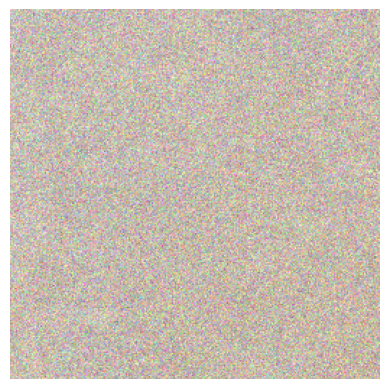

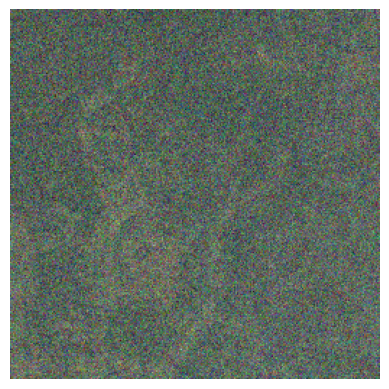

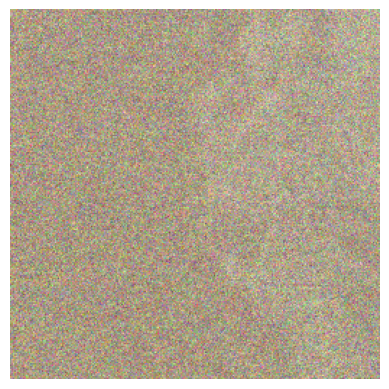

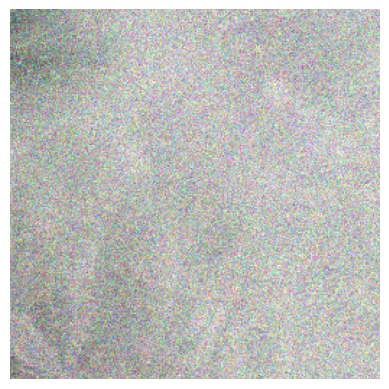

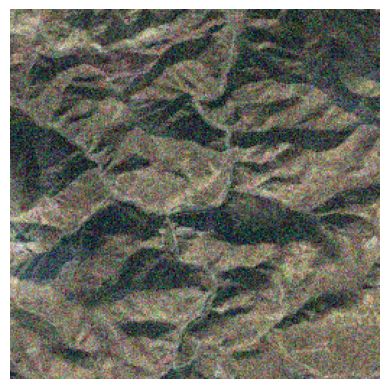

In [ ]:
def visualize_rice1_images(image_files, apply_noise=False):
    for img_path in image_files:
        img = read_image(img_path, apply_noise=apply_noise)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Visualize a subset of images from RICE1 with noise
visualize_rice1_images(train_crappy_list_rice1[:5], apply_noise=True)

# Visualize a subset of testing images from RICE1 without noise
#visualize_rice1_images(test_crappy_list_rice1[:5], apply_noise=False)

###RICE2

In [ ]:
def get_file_list_rice2(list_path, file_list):
    full_list = []
    for file in file_list:
        file_path = os.path.join(list_path, file)
        full_list.append(file_path)
    return full_list

In [ ]:
# Define the root directory for the RICE2 dataset
rice2_root = '/content/drive/MyDrive/CVProject/RICE_DATASET/RICE2'

# Get the lists of image files for 'cloud' and 'label' directories
rice2_cloud_files = os.listdir(os.path.join(rice2_root, 'cloud'))
rice2_label_files = os.listdir(os.path.join(rice2_root, 'label'))

# Split ratio for training and testing sets
split_ratio = 0.8

# Divide the dataset into training and testing sets
div_index = int(split_ratio * len(rice2_cloud_files))

# Generate full file paths
rice2_cloud_full_paths = get_file_list_rice2(os.path.join(rice2_root, 'cloud'), rice2_cloud_files)
rice2_label_full_paths = get_file_list_rice2(os.path.join(rice2_root, 'label'), rice2_label_files)

# Splitting the datasets
train_cloud_paths_rice2 = rice2_cloud_full_paths[:div_index]
test_cloud_paths_rice2 = rice2_cloud_full_paths[div_index:]

train_label_paths_rice2 = rice2_label_full_paths[:div_index]
test_label_paths_rice2 = rice2_label_full_paths[div_index:]

print(f'Train set: {len(train_cloud_paths_rice2)} images, Test set: {len(test_cloud_paths_rice2)} images')

Train set: 588 images, Test set: 148 images


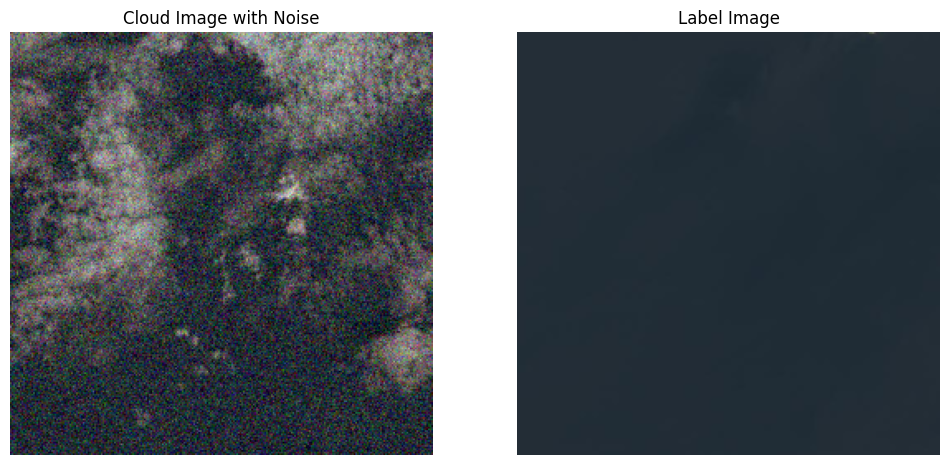

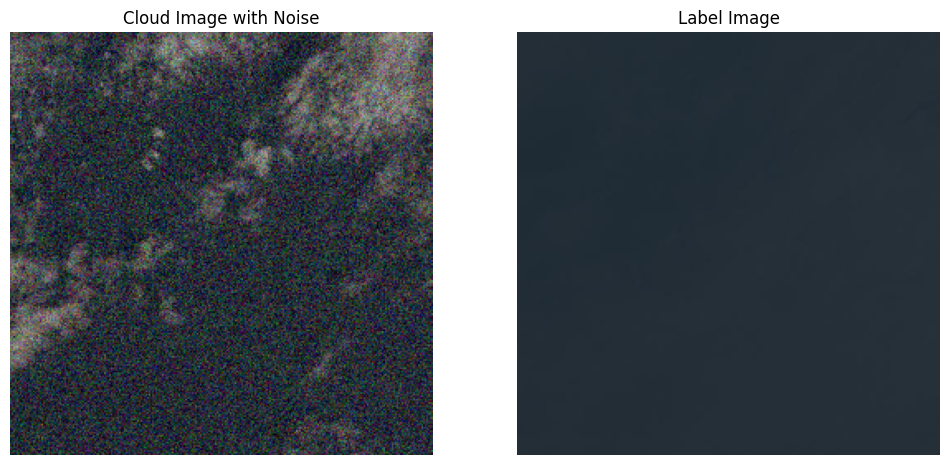

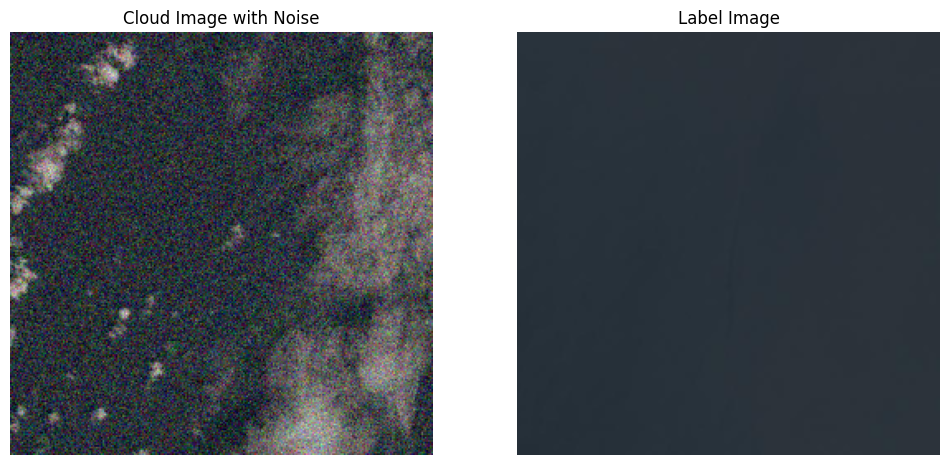

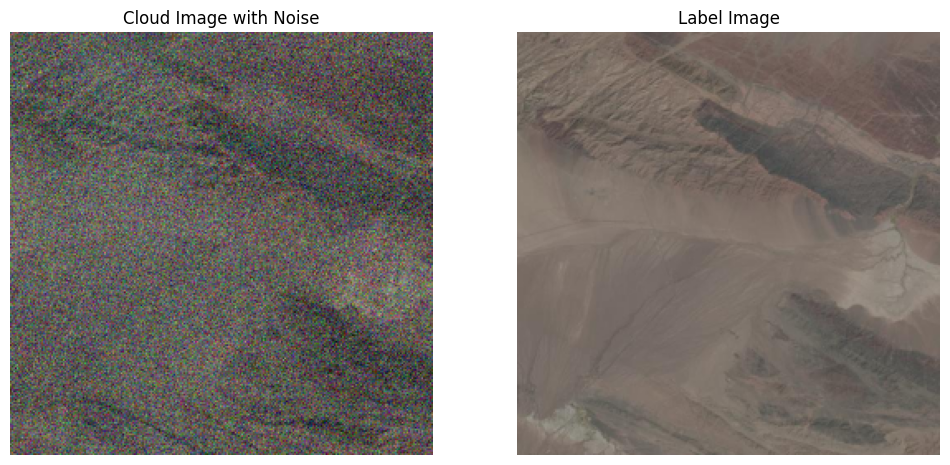

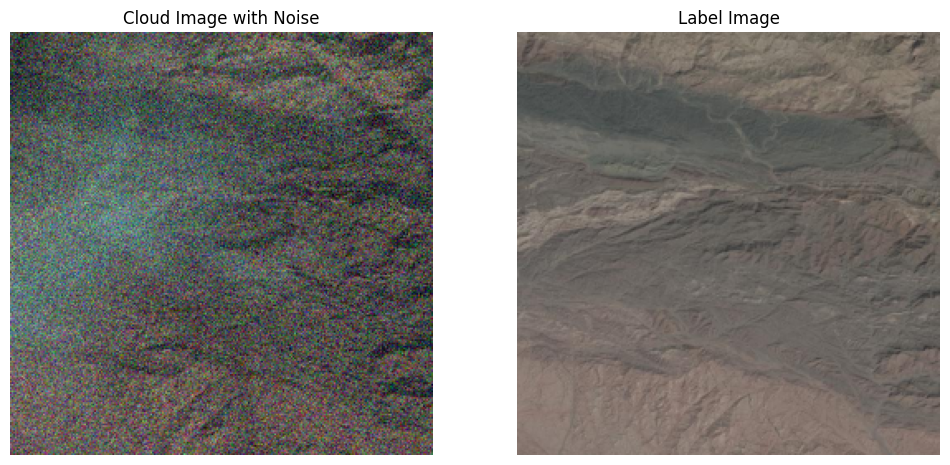

In [ ]:
def visualize_rice2_images(images, labels, apply_noise=False):
    for img_path, label_path in zip(images, labels):
        image = read_image(img_path, apply_noise=apply_noise)
        label = read_image(label_path)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Cloud Image' + (' with Noise' if apply_noise else ''))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(label)
        plt.title('Label Image')
        plt.axis('off')

        plt.show()

# Visualize the first 5 pairs of images and labels with noise
visualize_rice2_images(rice2_cloud_full_paths[:5], rice2_label_full_paths[:5], apply_noise=True)

# Data Generators for RICE1 and RICE2 Datasets

In [ ]:
batch_size = 1

def train_generator(train_crappy_list, train_target_list, apply_noise=False):
    while True:
        for start in range(0, len(train_target_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_target_list))
            ids_train_batch_crappy = train_crappy_list[start:end]
            ids_train_batch_target = train_target_list[start:end]

            for x, y in zip(ids_train_batch_crappy, ids_train_batch_target):
                img_y = read_image(y)
                img_x = read_image(x, apply_noise=apply_noise)
                x_batch.append(np.array(img_x, np.float32) / 255.)
                y_batch.append(np.array(img_y, np.float32) / 255.)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            yield x_batch, y_batch

def test_generator(test_crappy_list, test_target_list):
    while True:
        for start in range(0, len(test_target_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(test_target_list))
            ids_test_batch_crappy = test_crappy_list[start:end]
            ids_test_batch_target = test_target_list[start:end]

            for x, y in zip(ids_test_batch_crappy, ids_test_batch_target):
                img_y = read_image(y)
                img_x = read_image(x)
                x_batch.append(np.array(img_x, np.float32) / 255.)
                y_batch.append(np.array(img_y, np.float32) / 255.)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            yield x_batch, y_batch

def create_dataset(crappy_list, target_list, apply_noise=False):
    x_batch = []
    y_batch = []
    for x, y in zip(crappy_list, target_list):
        img_y = read_image(y)
        img_x = read_image(x, apply_noise=apply_noise)
        # Transpose the image to have channels first
        img_x = np.transpose(img_x, (2, 0, 1))
        img_y = np.transpose(img_y, (2, 0, 1))
        x_batch.append(np.array(img_x, np.float32) / 255.)
        y_batch.append(np.array(img_y, np.float32) / 255.)
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)
    return x_batch, y_batch

In [ ]:
# Example usage for RICE1 and RICE2 datasets
train_data_rice1 = create_dataset(train_crappy_list_rice1, train_target_list_rice1, apply_noise=True)
test_data_rice1 = create_dataset(test_crappy_list_rice1, test_target_list_rice1)

train_data_rice2 = create_dataset(train_cloud_paths_rice2, train_label_paths_rice2, apply_noise=True)
test_data_rice2 = create_dataset(test_cloud_paths_rice2, test_label_paths_rice2)

# Print statements to verify dataset shapes
print("RICE1 Training Data Shape:", train_data_rice1[0].shape, "Target Shape:", train_data_rice1[1].shape)
print("RICE1 Testing Data Shape:", test_data_rice1[0].shape, "Target Shape:", test_data_rice1[1].shape)
print("RICE2 Training Data Shape:", train_data_rice2[0].shape, "Target Shape:", train_data_rice2[1].shape)
print("RICE2 Testing Data Shape:", test_data_rice2[0].shape, "Target Shape:", test_data_rice2[1].shape)

RICE1 Training Data Shape: (400, 3, 256, 256) Target Shape: (400, 3, 256, 256)
RICE1 Testing Data Shape: (100, 3, 256, 256) Target Shape: (100, 3, 256, 256)
RICE2 Training Data Shape: (588, 3, 256, 256) Target Shape: (588, 3, 256, 256)
RICE2 Testing Data Shape: (148, 3, 256, 256) Target Shape: (148, 3, 256, 256)


# Loss Function

In [ ]:
import torch.nn as nn
from torchvision.models import vgg19

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg19(pretrained=True).features[:10]  # Using VGG up to 10th layer
        self.vgg = vgg.eval()  # Set VGG to evaluation mode
        self.mse_loss = nn.MSELoss()

        # Freeze VGG parameters
        for parameter in self.vgg.parameters():
            parameter.requires_grad = False

    def forward(self, y_true, y_pred):
        y_true_features = self.vgg(y_true)
        y_pred_features = self.vgg(y_pred)
        return self.mse_loss(y_true_features, y_pred_features)

# Example usage
perceptual_loss = PerceptualLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 153MB/s]


In [ ]:
import torch
import torch.nn as nn

# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: (512 x 4 x 4)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: (256 x 8 x 8)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: (128 x 16 x 16)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: (64 x 32 x 32)
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output state size: (img_channels x 64 x 64)
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        # Concatenation of source and target images will double the channels
        self.model = nn.Sequential(
            # Initial convolution layers
            nn.Conv2d(input_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Increasing the depth while reducing size
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer
            nn.Conv2d(512, 512, kernel_size=4, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, src_img, target_img):
        # Concatenate source and target images along the channel dimension
        x = torch.cat([src_img, target_img], dim=1)
        return self.model(x)

In [ ]:
generator = Generator()
input_channels = 3
discriminator = Discriminator(input_channels)

In [ ]:
# Define optimizers for the generator and discriminator
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# RUnet Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def pixel_shuffle(scale):
    return nn.PixelShuffle(upscale_factor=scale)

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding='same', stride=1, r=False):
        super(DownBlock, self).__init__()
        padding = kernel_size[0] // 2
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.r = r
        if self.r:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1, stride, padding)

    def forward(self, x):
        residual = x
        if self.r:
            residual = self.res_conv(residual)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return x

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, kernel_size=(3, 3), padding='same', stride=1, upscale_factor=2):
        super(UpBlock, self).__init__()

        self.pixel_shuffle = pixel_shuffle(upscale_factor)

        self.concat_bn = nn.BatchNorm2d(in_channels + skip_channels)
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x, skip):
        x = self.pixel_shuffle(x)
        x = torch.cat((x, skip), dim=1)
        x = self.concat_bn(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3), padding='same', stride=1):
        super(Bottleneck, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

In [ ]:
class RUNet(nn.Module):
    def __init__(self, input_size=256):
        super(RUNet, self).__init__()

        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.down2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DownBlock(64, 64),
            DownBlock(64, 64),
            DownBlock(64, 64),
            DownBlock(64, 128, r=True)
        )

        self.down3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DownBlock(128, 128),
            DownBlock(128, 128),
            DownBlock(128, 128),
            DownBlock(128, 256, r=True)
        )

        self.down4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DownBlock(256, 256),
            DownBlock(256, 256),
            DownBlock(256, 256),
            DownBlock(256, 256),
            DownBlock(256, 512, r=True)
        )

        self.down5 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            DownBlock(512, 512),
            DownBlock(512, 512)
        )

        self.bottleneck1 = Bottleneck(512, 1024)
        self.bottleneck2 = Bottleneck(1024, 512)

        self.up1 = UpBlock(512, 512, 512)
        self.up2 = UpBlock(512, 384, 256)
        self.up3 = UpBlock(384, 256, 128)
        self.up4 = UpBlock(256, 96, 64)

        self.up5 = nn.Sequential(
            pixel_shuffle(2),
            nn.Conv2d(96, 99, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(99, 99, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True)
        )

        self.output_conv = nn.Conv2d(99, 3, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        # Down Blocks
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)

        # Bottleneck Blocks
        bn1 = self.bottleneck1(down5)
        bn2 = self.bottleneck2(bn1)

        # Up Blocks
        up1 = self.up1(bn2, down5)
        up2 = self.up2(up1, down4)
        up3 = self.up3(up2, down3)
        up4 = self.up4(up3, down2)

        # Final Up Block and Output
        up5 = self.up5(up4)
        out = self.output_conv(up5)

        return out

In [ ]:
unet_model = RUNet()
print(unet_model)

RUNet(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DownBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DownBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kern

# Training Unet

In [ ]:
import torch
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim_torch(img1, img2, window_size=11, size_average=True):
    channel = img1.size(1)
    window = create_window(window_size, channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

# Example usage
# img1 and img2 should be PyTorch tensors of shape [batch_size, channels, height, width]
# For example: ssim_score = ssim_torch(img1, img2)

# Define PSNR and SSIM functions for PyTorch
def psnr_torch(original, compressed):
    mse = torch.mean((original - compressed) ** 2)
    if mse == 0:
        return torch.tensor(100)
    max_pixel = 255.0
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import math
import os

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = RUNet().to(device)
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0015)
criterion = torch.nn.MSELoss()

train_loader = DataLoader(train_data_rice1, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data_rice1, batch_size=10)

best_ssim = 0
best_psnr = 0
num_epochs = 250

for epoch in range(num_epochs):
    unet_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():  # For mixed precision
            outputs = unet_model(inputs)
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    torch.cuda.empty_cache()

    # Evaluation
    unet_model.eval()
    with torch.no_grad():
        total_ssim, total_psnr = 0, 0
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = unet_model(inputs)
            total_ssim += ssim_torch(outputs, targets)
            total_psnr += psnr_torch(outputs, targets)

        avg_ssim = total_ssim / len(test_loader)
        avg_psnr = total_psnr / len(test_loader)
        print(f"Epoch {epoch+1}, SSIM: {avg_ssim}, PSNR: {avg_psnr}")

        # Checkpointing
        if avg_ssim > best_ssim:
            best_ssim = avg_ssim
            torch.save(unet_model.state_dict(), '/content/gdrive/MyDrive/best_ssim/unet.pth')
        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            torch.save(unet_model.state_dict(), '/content/gdrive/MyDrive/best_psnr/unet.pth')

# Load best model for testing
unet_model.load_state_dict(torch.load('/content/gdrive/MyDrive/unet_sr_best_best/unet.pth'))

# GAN

In [ ]:
import torch
import torch.nn as nn

class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, src_images):
        # Generate images
        generated_images = self.generator(src_images)

        # Disable gradient calculations for the discriminator to keep its weights constant
        for param in self.discriminator.parameters():
            param.requires_grad = False

        # Get discriminator output for real and fake image pairs
        gan_output = self.discriminator(src_images, generated_images)

        # Re-enable gradients for discriminator
        for param in self.discriminator.parameters():
            param.requires_grad = True

        return gan_output, generated_images

# Assume g_model and d_model are your generator and discriminator models
g_model = RUNet()
d_model = Discriminator(input_channels)

# Create the GAN model
gan_model = GAN(g_model, d_model)

# Train GAN

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from torchvision.utils import save_image

# Assuming g_model is your generator, d_model is your discriminator,
# and gan_model is your combined GAN model (as previously defined)
# Also assuming train_dataset and test_dataset are PyTorch Dataset objects

# Define DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset_rice1, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset_rice1, batch_size=8)

# Define optimizers for the generator and discriminator
gen_optimizer = torch.optim.Adam(g_model.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(d_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define loss criterion
criterion = torch.nn.BCELoss()

# Training loop
n_epochs = 200
max_psnr, max_ssim = 25, 0.86
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(n_epochs):
    for i, (real_A, real_B) in enumerate(train_loader):
        real_A, real_B = real_A.to(device), real_B.to(device)
        # Generate fake images
        fake_B = g_model(real_A)

        # Train Discriminator
        disc_optimizer.zero_grad()
        disc_real = d_model(real_A, real_B)
        disc_fake = d_model(real_A, fake_B.detach())  # Detach generator
        real_label = torch.ones_like(disc_real)
        fake_label = torch.zeros_like(disc_fake)
        disc_loss_real = criterion(disc_real, real_label)
        disc_loss_fake = criterion(disc_fake, fake_label)
        disc_loss = (disc_loss_real + disc_loss_fake) / 2
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        disc_fake = d_model(real_A, fake_B)
        gen_loss = criterion(disc_fake, real_label)
        gen_loss.backward()
        gen_optimizer.step()

        # Print/log your losses here
        print(f'Epoch [{epoch}/{n_epochs}], Step [{i}/{len(train_loader)}], '
              f'Disc Loss: {disc_loss.item()}, Gen Loss: {gen_loss.item()}')

    # Evaluate and save models here
    # You can use functions like `calculate_psnr` and `calculate_ssim` as needed
    current_ssim = ssim_torch()
    current_psnr = psnr_torch()
    # Save models if they improve
    if current_psnr > max_psnr:
        torch.save(g_model.state_dict(), 'generator_max_psnr.pth')
        max_psnr = current_psnr
    if current_ssim > max_ssim:
        torch.save(g_model.state_dict(), 'generator_max_ssim.pth')
        max_ssim = current_ssim

# Load the best model for testing
g_model.load_state_dict(torch.load('generator_max_psnr.pth'))

Epoch [1/5], Step [1/20], Disc Loss: 0.46, Gen Loss: 0.66
Epoch [1/5], Step [2/20], Disc Loss: 0.18, Gen Loss: 0.52
Epoch [1/5], Step [3/20], Disc Loss: 0.38, Gen Loss: 0.57
Epoch [1/5], Step [4/20], Disc Loss: 0.19, Gen Loss: 0.48
Epoch [1/5], Step [5/20], Disc Loss: 0.19, Gen Loss: 0.61
Epoch [1/5], Step [6/20], Disc Loss: 0.26, Gen Loss: 0.49
Epoch [1/5], Step [7/20], Disc Loss: 0.44, Gen Loss: 0.59
Epoch [1/5], Step [8/20], Disc Loss: 0.46, Gen Loss: 0.62
Epoch [1/5], Step [9/20], Disc Loss: 0.19, Gen Loss: 0.48
Epoch [1/5], Step [10/20], Disc Loss: 0.39, Gen Loss: 0.56
Epoch [1/5], Step [11/20], Disc Loss: 0.44, Gen Loss: 0.57
Epoch [1/5], Step [12/20], Disc Loss: 0.19, Gen Loss: 0.54
Epoch [1/5], Step [13/20], Disc Loss: 0.39, Gen Loss: 0.55
Epoch [1/5], Step [14/20], Disc Loss: 0.24, Gen Loss: 0.63
Epoch [1/5], Step [15/20], Disc Loss: 0.40, Gen Loss: 0.56
Epoch [1/5], Step [16/20], Disc Loss: 0.30, Gen Loss: 0.54
Epoch [1/5], Step [17/20], Disc Loss: 0.39, Gen Loss: 0.48
Epoch 

# Testing

In [ ]:
import torch
from torchvision.utils import save_image
import os
import numpy as np

# Assuming test_loader is a PyTorch DataLoader for your test dataset
# and g_model is your trained generator model
# Also assuming psnr_torch and ssim_torch functions are defined as before

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g_model.eval()  # Set the model to evaluation mode

psnr_total = 0.0
ssim_total = 0.0
samples = 0

# Directory to save results
result_dir = '/content/results/'
os.makedirs(result_dir, exist_ok=True)

with torch.no_grad():
    for i, (real_A, real_B) in enumerate(test_loader):
        real_A, real_B = real_A.to(device), real_B.to(device)
        fake_B = g_model(real_A)

        for j in range(real_A.size(0)):
            # Save real and fake images for visual inspection
            save_image(real_A[j], os.path.join(result_dir, f'input_{samples + j}.png'))
            save_image(real_B[j], os.path.join(result_dir, f'target_{samples + j}.png'))
            save_image(fake_B[j], os.path.join(result_dir, f'fake_{samples + j}.png'))

            # Calculate PSNR and SSIM
            psnr_score = psnr_torch(real_B[j], fake_B[j]).item()
            ssim_score = ssim_torch(real_B[j], fake_B[j]).item()

            psnr_total += psnr_score
            ssim_total += ssim_score

            samples += 1

# Calculate average PSNR and SSIM
avg_psnr = psnr_total / samples
avg_ssim = ssim_total / samples

print("Average SSIM: ", avg_ssim, "Average PSNR: ", avg_psnr)

Average SSIM:  0.75 Average PSNR:  24.3
